In [2]:
import os
from astropy.table import Table
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import fitsio
%matplotlib inline

In [3]:
import desisim
import desisurvey
import desimodel.io
import desimodel.footprint

# Environment Variables 

Set some environment variables and create output directories

`$DESISURVEY` = `${SCRATCH}`/quicksurvey_example/survey/

In [4]:
basedir = os.path.join(os.getenv('SCRATCH'),'quicksurvey_example')
surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir,'survey')
fiberassigndir =  os.path.join(basedir, 'fiberassign')
targetdir = os.path.join(basedir,'targets')
zcatbrightdir = os.path.join(basedir,'zcat/bright')
zcatdarkdir = os.path.join(basedir,'zcat/dark')
zcatalldir = os.path.join(basedir,'zcat/all')

In [6]:
print('basedir:', basedir)
print('surveydir:', os.environ['DESISURVEY_OUTPUT'])
print('fiberassigndir:', fiberassigndir)
print('targets:', targetdir)
print('zcatbritghdir:', zcatbrightdir)
print('zcatdarkdir:', zcatdarkdir)
print('zcatalldir:', zcatalldir)

basedir: /global/cscratch1/sd/forero/quicksurvey_example
surveydir: /global/cscratch1/sd/forero/quicksurvey_example/survey
fiberassigndir: /global/cscratch1/sd/forero/quicksurvey_example/fiberassign
targets: /global/cscratch1/sd/forero/quicksurvey_example/targets
zcatbritghdir: /global/cscratch1/sd/forero/quicksurvey_example/zcat/bright
zcatdarkdir: /global/cscratch1/sd/forero/quicksurvey_example/zcat/dark
zcatalldir: /global/cscratch1/sd/forero/quicksurvey_example/zcat/all


In [ ]:
os.makedirs(surveydir, exist_ok=True)
os.makedirs(fiberassigndir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(zcatbrightdir, exist_ok=True)
os.makedirs(zcatdarkdir, exist_ok=True)
os.makedirs(zcatalldir, exist_ok=True)

# Survey Plan

We create a list of tiles to be observed by running `surveyplan` and `surveysim` for the first year of the survey.
The configuration file we used is

In [8]:
cmd  = 'cat  {}/config.yaml'.format(os.environ['DESISURVEY_OUTPUT'])
! $cmd

####################################################################
# Configuration data for DESI survey planning and scheduling.
####################################################################

#-------------------------------------------------------------------
# Location of the Mayall at KPNO
#-------------------------------------------------------------------

location:
    latitude: 31.963972222 deg
    longitude: -111.599336111 deg
    elevation: 2120 m
    pressure: 78318 Pa    # from 1976 standard atmosphere model
    temperature: 5 C      # a guess at mean night-time temperature
    timezone: US/Arizona

#-------------------------------------------------------------------
# Observing calendar.
#-------------------------------------------------------------------

# Survey nominally starts on night of this date. Format is YYYY-MM-DD.
first_day: 2019-12-01

# Survey nominally ends on morning of this date. Format is YYYY-MM-DD.
last_day: 2020-11-30

# First night of monsoon 

And the detailed script is

In [9]:
cmd  = 'cat  {}/surveysim_baseline.sh'.format(os.environ['DESISURVEY_OUTPUT'])
! $cmd

#!/bin/bash
#############################################################################
# Simulate the baseline survey strategy described in DESI-doc-1767-v3.
# Note that this is one random realization of the observing conditions.
# Change the random seed for a different realization.
# This will take ~1 hours to run and writes ~50MB to $DESISURVEY_OUTPUT.
#############################################################################
export DESISURVEY_OUTPUT=${SCRATCH}'/quicksurvey_example/survey'

INIT_ARGS='--verbose --config-file '${DESISURVEY_OUTPUT}/'config.yaml'
PLAN_ARGS='--verbose --fa-delay 1m --config-file '${DESISURVEY_OUTPUT}/'config.yaml'
SIM_ARGS='--verbose --seed 123 --strategy HA+fallback --config-file '${DESISURVEY_OUTPUT}/'config.yaml'

surveyinit ${INIT_ARGS}
surveyplan --create ${PLAN_ARGS}
surveysim ${SIM_ARGS}

while :
do
    (surveyplan ${PLAN_ARGS}) || break
    (surveysim --resume ${SIM_ARGS}) || break
done


This takes almost four hours to run. 
If you don't want to run it, you can skip to **Run Select Mock Targets**

In [10]:
cmd  = '{}/surveysim_baseline.sh'.format(os.environ['DESISURVEY_OUTPUT'])
print(cmd)
# !$cmd

/global/cscratch1/sd/forero/quicksurvey_example/survey/surveysim_baseline.sh


# Read exposures list
Select a subset of tiles selected to have dark, gray, and bright.
Bright twilight tiles should be excluded because we don't have a right sky model, but we are including them here anyway.

In [27]:
from desisurvey.progress import Progress
p = Progress('progress.fits')
explist = p.get_exposures()
isbright = explist['pass'] > 4 
isgray = explist['pass'] == 4
isdark = explist['pass'] < 4
istwilight = isbright & (explist['moonalt'] < 0)

INFO:progress.py:145:__init__: Loaded progress from /global/cscratch1/sd/forero/quicksurvey_example/survey/progress.fits.


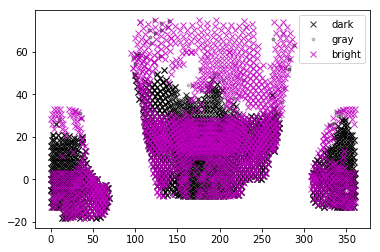

In [28]:
plt.plot(explist['ra'][isdark], explist['dec'][isdark], 'kx', alpha=0.8, label='dark')
plt.plot(explist['ra'][isgray], explist['dec'][isgray], 'k.', alpha=0.2, label='gray')
plt.plot(explist['ra'][isbright], explist['dec'][isbright], 'mx', alpha=0.8, label='bright')
plt.legend(loc='upper right')

Pick 10 tiles nearest RA=180, dec=18

In [42]:
tiles = desimodel.io.load_tiles()

ntiles = 20
xtiles = tiles[np.in1d(tiles['TILEID'], explist['tileid'])]
xyz = hp.ang2vec(xtiles['ra'], xtiles['dec'], lonlat=True)
center = hp.ang2vec(180, 18, lonlat=True)
d2 = ((xyz - center)**2).sum(axis=1)
ii = np.argsort(d2)[0:ntiles]
xtiles = xtiles[ii]
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, xtiles)
nexp = np.count_nonzero(np.in1d(explist['tileid'], xtiles['TILEID']) & ~istwilight)
print('{} tiles covered by {} exposures and {} healpixels'.format(len(xtiles), nexp, len(pixels)))

20 tiles covered by 29 exposures and 78 healpixels


In [43]:
#- row indices of exposures of the selected tiles
iobs = np.where(np.in1d(explist['tileid'], xtiles['TILEID']))[0]
assert np.all(np.in1d(explist['tileid'][iobs], xtiles['TILEID']))
print(iobs)
print(pixels, len(pixels))
explist[iobs]

[ 533  534  769  770  906  907  953  954 1235 1236 1237 1238 1280 1281 1786
 1887 1888 2070 2071 2072 2073 2346 2347 2348 2387 2441 2442 2541 2542 3827
 3828 3863 3894]
[27855 27864 27865 27866 27867 27868 27869 27870 27871 27875 27876 27877
 27878 27879 27881 27884 27885 27886 27887 27888 27889 27890 27891 27892
 27893 27894 27895 27896 27897 27898 27899 27900 27901 27902 27903 28042
 28043 28046 28064 28065 28066 28067 28068 28070 28072 28073 28074 28075
 28076 28078 28229 28231 28240 28241 28242 28243 28244 28245 28246 28247
 28248 28249 28252 28253 28255 28416 28417 28418 28419 28420 28421 28422
 28423 28424 28425 28426 28427 28428] 78


tileid,pass,ra,dec,ebmv,night,mjd,exptime,seeing,transparency,airmass,moonfrac,moonalt,moonsep
,,,,,,,s,arcsec,,,,deg,deg
int32,int16,float64,float64,float32,bytes10,float64,float64,float64,float64,float64,float64,float64,float64
28522,4,178.48,15.73,0.0423507,2019-12-22,58840.5165736,779.645150798,0.813759863377,0.920826971531,1.06578261356,0.0997386220394,5.8848570772,66.2024111436
28522,4,178.48,15.73,0.0423507,2019-12-22,58840.5269862,762.301760085,0.813759863377,0.920826971531,1.06578261356,0.0997386220394,5.8848570772,66.2024111436
2812,0,180.0,15.83,0.0383665,2019-12-30,58848.5039011,716.288214843,1.1069227457,0.980842471123,1.05912436941,0.240230044044,-69.738675827,163.7188271
2812,0,180.0,15.83,0.0383665,2019-12-30,58848.5135804,692.01010596,1.1069227457,0.980842471123,1.05912436941,0.240230044044,-69.738675827,163.7188271
2816,0,181.5,18.38,0.0291605,2020-01-03,58852.4975099,674.821162938,1.00861132145,0.917113542557,1.04573990276,0.60504166833,-38.6150001811,145.217429659
2816,0,181.5,18.38,0.0291605,2020-01-03,58852.5067093,837.253546377,1.00861132145,0.917113542557,1.04573990276,0.60504166833,-38.6150001811,145.217429659
5477,0,178.5,18.38,0.0347319,2020-01-04,58853.4906076,591.160355461,1.08282589912,0.905983805656,1.04160046199,0.697037205017,-26.7284112578,131.543081872
5477,0,178.5,18.38,0.0347319,2020-01-04,58853.4988386,686.689088347,1.08282589912,0.905983805656,1.04160046199,0.697037205017,-26.7284112578,131.543081872


In [44]:
# save the reduce list of exposures for bright and dark/gray survey
mini_explist = explist[iobs]
isbright = mini_explist['pass'] > 4


exposurefile = os.path.join(surveydir,'exposures_bright.fits')
Table(mini_explist[isbright]).write(exposurefile, overwrite=True)


exposurefile = os.path.join(surveydir,'exposures_dark.fits')
Table(mini_explist[~isbright]).write(exposurefile, overwrite=True)


exposurefile = os.path.join(surveydir,'exposures_all.fits')
Table(mini_explist).write(exposurefile, overwrite=True)

In [45]:
Table(mini_explist[isbright])

tileid,pass,ra,dec,ebmv,night,mjd,exptime,seeing,transparency,airmass,moonfrac,moonalt,moonsep
,,,,,,,s,arcsec,,,,deg,deg
int32,int16,float64,float64,float32,bytes10,float64,float64,float64,float64,float64,float64,float64,float64
34284,5,179.56,15.71,0.0397849,2020-02-03,58883.4120587,389.298731366,0.749344289303,0.990513026714,1.05466244106,0.715661244866,2.00437158379,102.52759903
34280,5,177.89,18.24,0.0351981,2020-03-03,58912.3101413,634.216437929,1.43911993504,0.37843105197,1.06447327521,0.64988938111,27.4752497921,80.3636648367
34280,5,177.89,18.24,0.0351981,2020-03-03,58912.3188707,587.795705101,1.43911993504,0.37843105197,1.06447327521,0.64988938111,27.4752497921,80.3636648367
34285,5,180.9,18.26,0.0293757,2020-03-03,58912.3270628,432.488326209,1.0773627758,0.931544482708,1.05212034077,0.64988938111,22.5825831672,82.8337194701
34281,5,179.21,20.76,0.0305995,2020-03-04,58913.3021122,536.617091303,1.14801216125,0.978813529015,1.06851214777,0.748793155325,41.4850519411,67.6446535464
40046,6,180.64,15.68,0.0363845,2020-05-11,58981.1383438,375.609948746,1.23665261269,0.99452996254,1.06372200736,0.724207280023,-43.8206417472,119.340682488
40042,6,178.97,18.22,0.0331802,2020-05-11,58981.14408,498.018477556,1.56866669655,0.993786454201,1.04083371133,0.724207280023,-42.4557302888,121.718300026
40047,6,181.98,18.23,0.0308561,2020-05-13,58983.1395616,331.431198549,0.89466303587,0.994367897511,1.04703657781,0.529569920967,-61.9796938898,142.995506122


In [46]:
Table(mini_explist[~isbright])

tileid,pass,ra,dec,ebmv,night,mjd,exptime,seeing,transparency,airmass,moonfrac,moonalt,moonsep
,,,,,,,s,arcsec,,,,deg,deg
int32,int16,float64,float64,float32,bytes10,float64,float64,float64,float64,float64,float64,float64,float64
28522,4,178.48,15.73,0.0423507,2019-12-22,58840.5165736,779.645150798,0.813759863377,0.920826971531,1.06578261356,0.0997386220394,5.8848570772,66.2024111436
28522,4,178.48,15.73,0.0423507,2019-12-22,58840.5269862,762.301760085,0.813759863377,0.920826971531,1.06578261356,0.0997386220394,5.8848570772,66.2024111436
2812,0,180.0,15.83,0.0383665,2019-12-30,58848.5039011,716.288214843,1.1069227457,0.980842471123,1.05912436941,0.240230044044,-69.738675827,163.7188271
2812,0,180.0,15.83,0.0383665,2019-12-30,58848.5135804,692.01010596,1.1069227457,0.980842471123,1.05912436941,0.240230044044,-69.738675827,163.7188271
2816,0,181.5,18.38,0.0291605,2020-01-03,58852.4975099,674.821162938,1.00861132145,0.917113542557,1.04573990276,0.60504166833,-38.6150001811,145.217429659
2816,0,181.5,18.38,0.0291605,2020-01-03,58852.5067093,837.253546377,1.00861132145,0.917113542557,1.04573990276,0.60504166833,-38.6150001811,145.217429659
5477,0,178.5,18.38,0.0347319,2020-01-04,58853.4906076,591.160355461,1.08282589912,0.905983805656,1.04160046199,0.697037205017,-26.7284112578,131.543081872
5477,0,178.5,18.38,0.0347319,2020-01-04,58853.4988386,686.689088347,1.08282589912,0.905983805656,1.04160046199,0.697037205017,-26.7284112578,131.543081872


Plot the tiles and pixels

(13, 23)

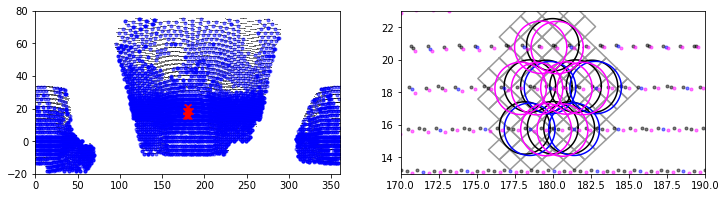

In [47]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plt.plot(x,y, '-', color=color)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plt.plot(ra, dec, '-', color='0.6')

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(tiles['RA'], tiles['DEC'], 'k,', alpha=0.5)
plt.plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plt.plot(xtiles['RA'], xtiles['DEC'], 'rx')
plt.xlim(0,360); plt.ylim(-20, 80)

plt.subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='black', GRAY='blue', BRIGHT='magenta')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plt.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = xtiles['PROGRAM'] == program
    for t in xtiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

plt.xlim(170, 190); plt.ylim(13, 23)

In [49]:
#- Write subset of tiles table to file for input to select_mock_targets --no-spectra
tilefile = os.path.join(targetdir,'test-tiles.fits')
Table(xtiles).write(tilefile, overwrite=True)
Table(xtiles)

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
28523,179.82,18.28,4,1,0.0313865,1.05912,1264.66,1.30052,GRAY,2
11239,179.58,18.36,1,1,0.0315597,1.05874,1255.09,1.3013,DARK,1
34285,180.9,18.26,5,1,0.0293757,1.05921,1317.01,1.28485,BRIGHT,4
40042,178.97,18.22,6,1,0.0331802,1.05941,1279.58,1.31524,BRIGHT,4
5477,178.5,18.38,0,1,0.0347319,1.05864,1288.91,1.32651,DARK,1
2816,181.5,18.38,0,1,0.0291605,1.05864,1349.34,1.2823,DARK,1
40047,181.98,18.23,6,1,0.0308561,1.05936,1377.31,1.2967,BRIGHT,4
34280,177.89,18.24,5,1,0.0351981,1.05931,1293.38,1.33133,BRIGHT,4
2812,180.0,15.83,0,1,0.0383665,1.07202,1529.38,1.37763,DARK,1


# Run select_mock_targets

In [ ]:
configfile = os.path.join(targetdir,'select-mock-targets.yaml')
os.environ['MPICH_GNI_FORK_MODE'] = 'FULLCOPY'
os.environ['KMP_AFFINITY'] = 'disabled'
os.environ['OMP_NUM_THREADS'] = '1'
cmd = "srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00"
cmd += " mpi_select_mock_targets -O {targetdir} --config {configfile}"
cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile} --no-spectra"
cmd = cmd.format(targetdir=targetdir, tilefile=tilefile, configfile=configfile)
print(cmd)

In [ ]:
#!$cmd

In [ ]:
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
!$cmd

In [ ]:
# some sanity checks on the results

In [ ]:
targets = fitsio.read(targetdir+'/targets.fits')
truth   = fitsio.read(targetdir+'/truth.fits')
mtl     = fitsio.read(targetdir+'/mtl.fits')
std     = fitsio.read(targetdir+'/standards-dark.fits')
sky     = fitsio.read(targetdir+'/sky.fits')

In [ ]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plt.plot(std['RA'], std['DEC'], 'm.')

# Run quicksurvey

Requires this [PR](https://github.com/desihub/desisim/pull/249) (branch `surveysim_epochs`)

## bright survey only

In [ ]:
quicksurvey_cmd = "quicksurvey -T {targetdir} -E {exposures}  --output_dir {outputdir} -f $(which fiberassign)"
quicksurvey_cmd += " -t {fiberassign_template} -D {fiberassign_dates}"

cmd = quicksurvey_cmd.format(targetdir=targetdir,
                             exposures=surveydir+'/exposures_bright.fits', 
                             outputdir=zcatbrightdir, 
                             fiberassign_template=fiberassigndir+'/template_fiberassign_bright.txt', 
                            fiberassign_dates=fiberassigndir+'/fiberassign_dates_bright.txt')
print(cmd)

In [ ]:
!$cmd

In [ ]:
zcat     = fitsio.read(zcatbrightdir+'/2/zcat.fits')
zcat_in_mtl = np.in1d(mtl['TARGETID'], zcat['TARGETID'])
plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], c='b', alpha=0.1, s=0.1)
plt.scatter(mtl[zcat_in_mtl]['RA'], mtl[zcat_in_mtl]['DEC'], c='r', alpha=0.4, s=1)
print(np.count_nonzero(zcat_in_mtl))

## dark survey only

In [ ]:
cmd = quicksurvey_cmd.format(targetdir=targetdir,
                             exposures=surveydir+'/exposures_dark.fits', 
                             outputdir=zcatdarkdir, 
                             fiberassign_template=fiberassigndir+'/template_fiberassign_dark.txt', 
                            fiberassign_dates=fiberassigndir+'/fiberassign_dates_dark.txt')
print(cmd)

In [ ]:
!$cmd

In [ ]:
zcat     = fitsio.read(zcatdarkdir+'/2/zcat.fits')
zcat_in_mtl = np.in1d(mtl['TARGETID'], zcat['TARGETID'])
plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], c='b', alpha=0.1, s=0.1)
plt.scatter(mtl[zcat_in_mtl]['RA'], mtl[zcat_in_mtl]['DEC'], c='r', alpha=0.4, s=1)
print(np.count_nonzero(zcat_in_mtl))

In [ ]:
cmd = quicksurvey_cmd.format(targetdir=targetdir,
                             exposures=surveydir+'/exposures_all.fits', 
                             outputdir=zcatalldir, 
                             fiberassign_template=fiberassigndir+'/template_fiberassign.txt', 
                            fiberassign_dates=fiberassigndir+'/fiberassign_dates.txt')
print(cmd)

In [ ]:
!$cmd

In [ ]:
zcat     = fitsio.read(zcatalldir+'/2/zcat.fits')
zcat_in_mtl = np.in1d(mtl['TARGETID'], zcat['TARGETID'])
plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], c='b', alpha=0.1, s=0.1)
plt.scatter(mtl[zcat_in_mtl]['RA'], mtl[zcat_in_mtl]['DEC'], c='r', alpha=0.4, s=1)
print(np.count_nonzero(zcat_in_mtl))